In [1]:
## Try prediction just using a recursive network 
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import csv

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


(600, 1)
(600, 6)
Training vs. Validation sets:


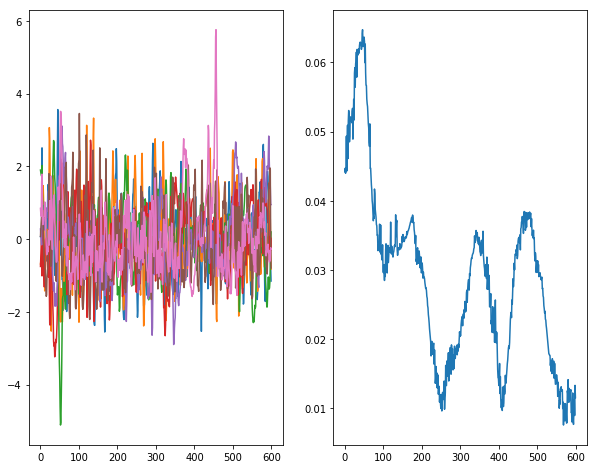

In [12]:
# Import chelsea's data
# Check times versus times.csv
# [t, x_tango, y_tango, z_tango, x_vicon, y_vicon, z_vicon, x_err_rate, y_err_rate, z_err_rate]
# Error rates, xyz
d_raw = (np.genfromtxt('trasnformed_data_slash_2.csv',delimiter=',')).astype(np.float32)
t_raw = d_raw[:,0]
t_img = (np.genfromtxt('rates.csv',delimiter=',')[:,0]).astype(np.float32)

## Align start of data streams
i_start = 0
for k in range(t_img.shape[0]):
    if(t_img[k]>t_raw[0]):
        i_start = k
        break
if i_start is 0:
    print('Warning! Time sequence alignment failed!')

# Extract and interpolate data
t_img = t_img[i_start:]
imu_data = (np.genfromtxt('rates.csv', delimiter=',')[i_start:,1:7]).astype(np.float32)
y_data = np.array([np.interp(t_img, t_raw, d_raw[:,7]), np.interp(t_img, t_raw, d_raw[:,8]), np.interp(t_img, t_raw, d_raw[:,9])]).T

# Should really automate this... or just re-save file.
flows_data = []
flows_data.append(np.load('flows_lowres_1_16.npy'))
flows_data.append(np.load('flows_lowres_2_16.npy'))
flows_data.append(np.load('flows_lowres_3_16.npy'))
flows_data.append(np.load('flows_lowres_4_16.npy'))
flows_data.append(np.load('flows_lowres_5_16.npy'))
flows_data.append(np.load('flows_lowres_6_16.npy'))
flows_data.append(np.load('flows_lowres_7_16.npy'))
flows_data.append(np.load('flows_lowres_8_16.npy'))
flows_data.append(np.load('flows_lowres_9_16.npy'))
flows_data.append(np.load('flows_lowres_10_16.npy'))
flows_data.append(np.load('flows_lowres_11_16.npy'))
flows_data.append(np.load('flows_lowres_12_16.npy'))
flows_data.append(np.load('flows_lowres_13_16.npy'))
flows_data.append(np.load('flows_lowres_14_16.npy'))
flows_data.append(np.load('flows_lowres_15_16.npy'))
#flows_data.append(np.load('flows_lowres_16_16.npy'))
flows_data = np.concatenate(flows_data,axis=0)
flows_data = flows_data[i_start:,:,:,:]


# Shorten datastream:
i_start = 600 # remove initial weird-ness
i_end = 1200
y_data = y_data[i_start:i_end,:]
imu_data = imu_data[i_start:i_end,:]
flows_data = flows_data[i_start:i_end,:,:,:]

# Flatten flows data into a "velocity" estimate
v = np.zeros((flows_data.shape[0],1))
for k in range(v.shape[0]):
    v[k,0] = np.linalg.norm(flows_data[k,:,:,:])

y_norm = np.zeros(y_data.shape[0]);
for k in range(y_data.shape[0]):
    y_norm[k] = np.linalg.norm(y_data[k,:])
y_data = y_norm

# Normalize imu data:
imu_data = imu_data - imu_data.mean(axis=0)
imu_data /= np.std(imu_data,axis=0)

# Normalize image data
v -= v.mean(axis=0)
v /= np.std(v,axis=0)

print(v.shape)
print(imu_data.shape)
x_data = np.concatenate([imu_data, v],axis=1)

N_training = int(0.6*x_data.shape[0])
N_validation = x_data.shape[0]- N_training
training_data_indices = np.random.choice(np.arange(x_data.shape[0]), N_training)
validation_data_indices = np.setdiff1d(np.arange(x_data.shape[0]), training_data_indices)


# sample batch_size subsequences of length sequence_length, and return the label at the end of the sequence
# These need to be randomized more - getting unwanted structure in the train/val split
def sample_minibatch(sequence_length, train=True,iseq=None):
    x_batch = np.zeros((sequence_length, x_data.shape[1]))
    y_batch = np.zeros(sequence_length)
    
    if(iseq is None):
        if(train):
            i_stop = 0
            while i_stop - sequence_length < 0 or i_stop + sequence_length >= y_data.shape[0]:
                i_stop = training_data_indices[np.random.randint(0,N_training)]
#                i_stop = np.random.randint(0,N_training)
        else:
            i_stop = 0
            while i_stop - sequence_length < 0 or i_stop + sequence_length >= y_data.shape[0]:
#                i_stop = N_training + np.random.randint(0,N_validation)
                i_stop = validation_data_indices[np.random.randint(0,N_validation)]
    else:
        i_stop = iseq
    x_batch = x_data[i_stop-sequence_length:i_stop,:]
    y_batch = y_data[i_stop-sequence_length:i_stop]
    return x_batch, y_batch, i_stop

def calc_rmse(predictions, targets):
    
    return np.sqrt(((predictions.reshape([-1]) - targets.reshape([-1])) ** 2).mean())

print('Training vs. Validation sets:')
plt.subplot(1,2,1)
plt.plot(x_data)
plt.subplot(1,2,2)
plt.plot(y_data)
plt.show()

In [13]:
# Definition of network:
# rescale the images ~ 64x48
# Try normalizing 
# feed output back in
# see if you can get cats roughly hte same size

OUTPUT_DIM = 1
BATCH_SIZE = 4
#SUB_BATCH_SIZE = 30
R_HISTORY = 32    # length of the time series

sub_batches = R_HISTORY*np.ones(BATCH_SIZE)

class tangoNet(object):

    # Extract features for a single time step
    def extract_features(self, input_data=None, reuse=True):
        if input_data is None:
            input_data = self.data
        x_r = input_data
        
        layers = []
        with tf.variable_scope('features', reuse=reuse):
            with tf.variable_scope('dense_1'):
                x_r = tf.layers.dense(x_r, 32, activation=tf.nn.relu)
                layers.append(x_r)
            return layers

    def __init__(self, batch_size, save_path=None, sess=None):
        self.batch_size = tf.constant(batch_size,dtype=tf.int32)
        # r_depth, batch, input_dim
        self.data   = tf.placeholder('float',shape=[R_HISTORY*batch_size,7],name='input_data_seq')
        # batch, output_dim
#        self.errs  = tf.placeholder('float',shape=[R_HISTORY*batch_size, OUTPUT_DIM],name='output_error')
        self.errs  = tf.placeholder('float',shape=[R_HISTORY*batch_size],name='output_error')
        self.lr = tf.placeholder('float',shape=[1],name='lr')

        self.layers = []
        self.features = []
        for k in range(R_HISTORY):
            data = self.data[batch_size*k:batch_size*(k+1),:]
            r = (k!=0)
            self.features.append(self.extract_features(data, reuse=r)[-1])
        
        with tf.variable_scope('core_lstm'):
            with tf.variable_scope('core_0'):
                x_r = self.features
                self.layers.append(x_r)
            with tf.variable_scope('core_1'):
                lstm_cell = tf.contrib.rnn.BasicLSTMCell(256)
                x_r, states = tf.contrib.rnn.static_rnn(lstm_cell, x_r, dtype=tf.float32, sequence_length=sub_batches)
                self.layers.append(x_r[-1])
            with tf.variable_scope('core_2'):
                W = tf.get_variable("weights", shape=[256,OUTPUT_DIM])
                b = tf.get_variable("bias", shape=[OUTPUT_DIM])
                x_r = tf.concat(x_r, axis=0)
                x_r = tf.matmul(x_r, W) + b
                self.layers.append(x_r)
        self.prediction = tf.reshape(x_r, [-1, OUTPUT_DIM])

        if save_path is not None:
            saver = tf.train.Saver()
            saver.restore(sess, save_path)
        # Needs a bit of work still
        self.rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(self.errs[-1], self.prediction[-1])))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.lr[0]).minimize(self.rmse)


Step:  100  MSE:  0.0826589  Val:  0.091167 LR:  0.004851495


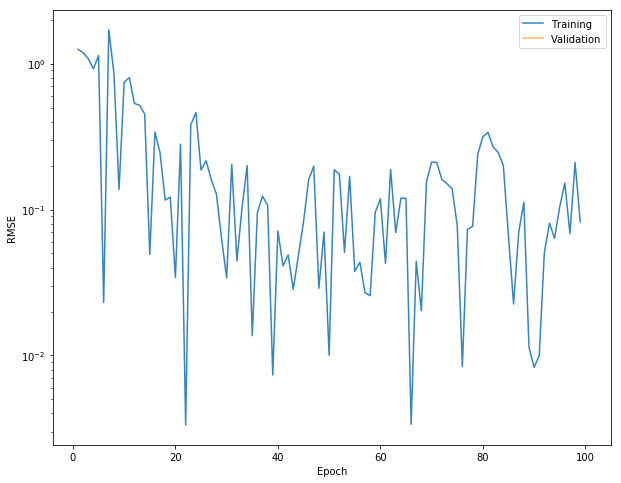

Step:  200  MSE:  0.0423681  Val:  0.0469957 LR:  0.004707400747005


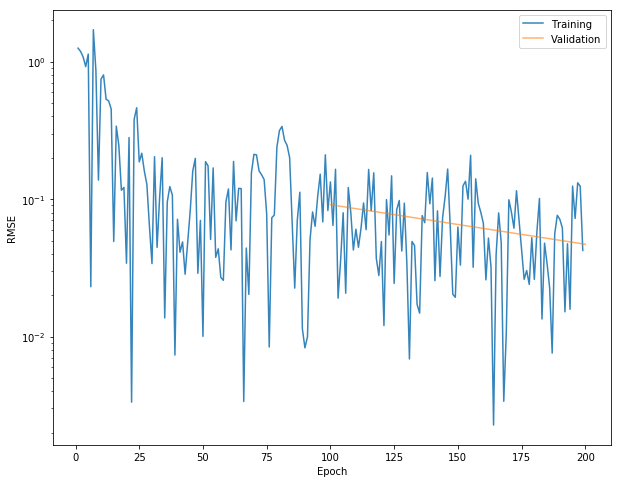

Step:  300  MSE:  0.0391879  Val:  0.0788971 LR:  0.004567586237418204


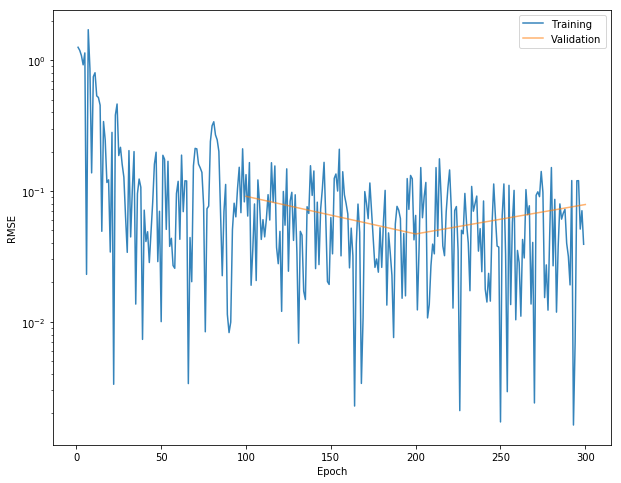

Step:  400  MSE:  0.00448516  Val:  0.0639954 LR:  0.00438760511499484


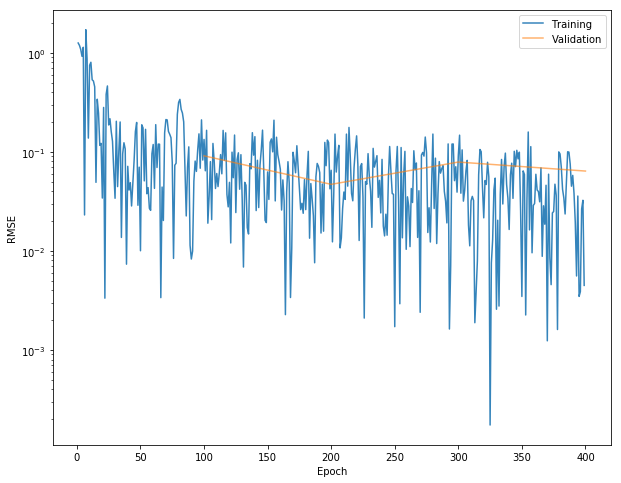

Step:  500  MSE:  0.0201562  Val:  0.0467564 LR:  0.0042572888554743785


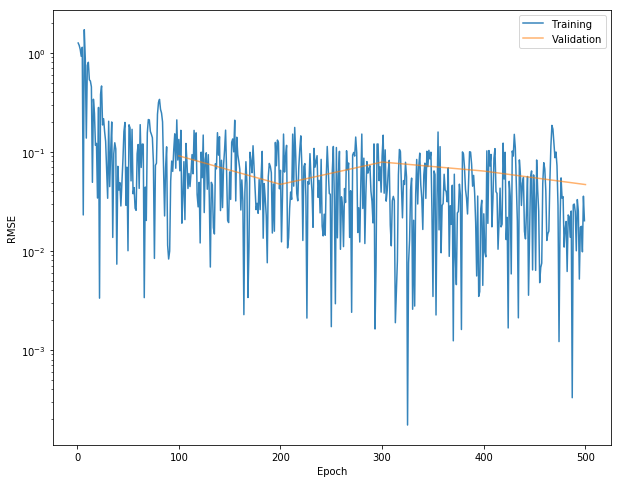

Step:  600  MSE:  0.0100059  Val:  0.0280271 LR:  0.0041308431191779335


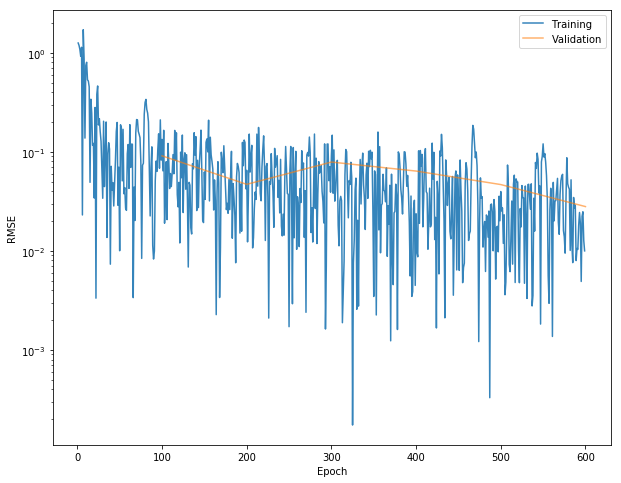

Step:  700  MSE:  0.00159512  Val:  0.0425479 LR:  0.003968071418218277


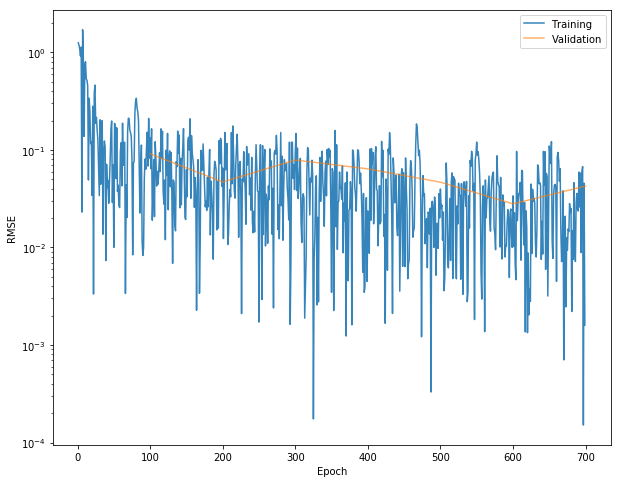

Step:  800  MSE:  0.000337586  Val:  0.0167014 LR:  0.003850215729025776


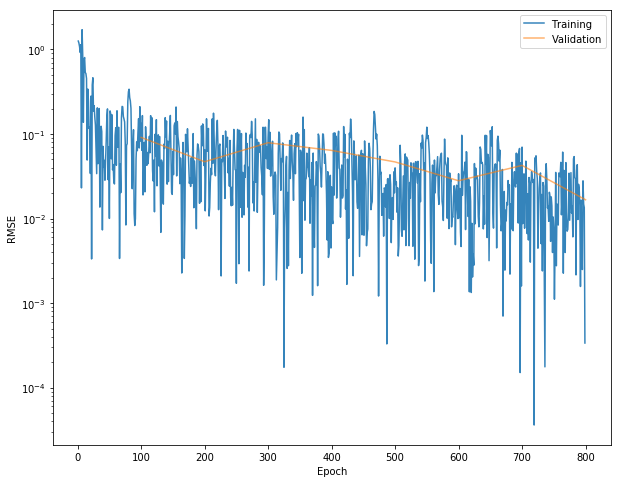

Step:  900  MSE:  0.00638031  Val:  0.0327292 LR:  0.0037358604716579815


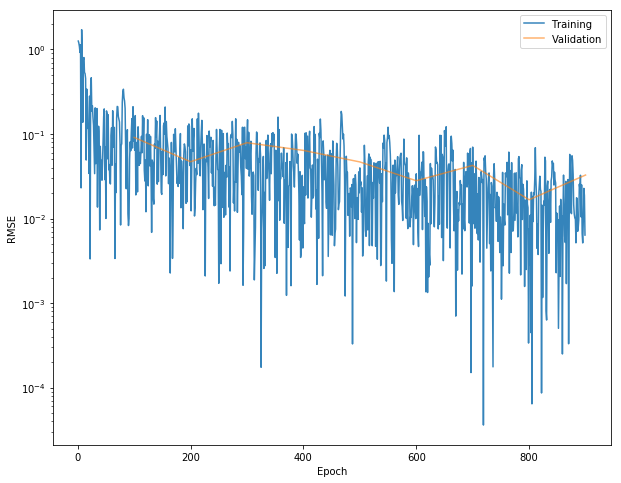

Step:  1000  MSE:  0.0191289  Val:  0.0216519 LR:  0.0035886526629913752


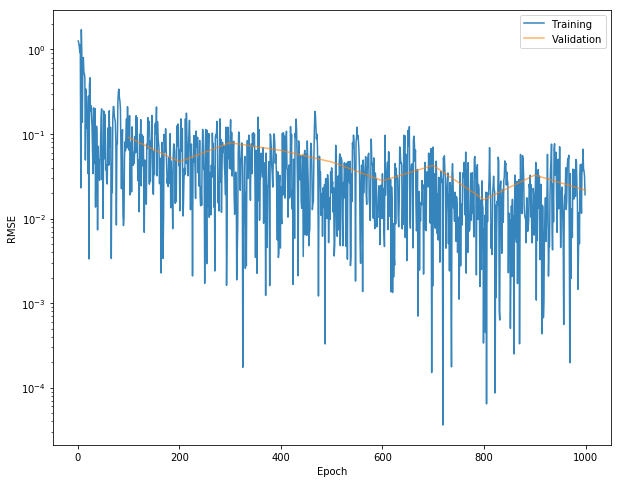

Step:  1100  MSE:  0.0113859  Val:  0.0128936 LR:  0.0034820660902478684


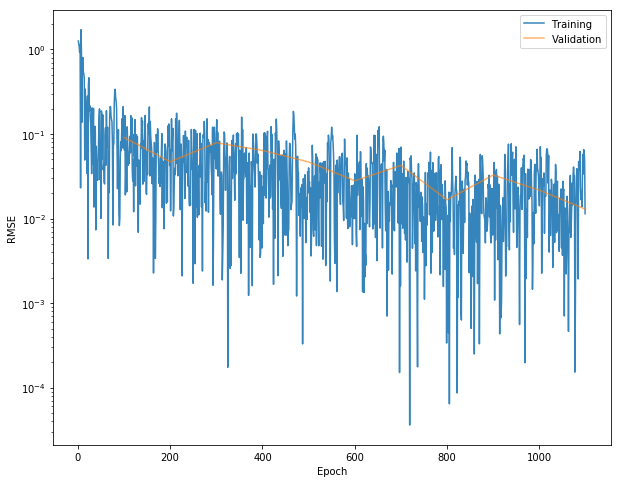

Step:  1200  MSE:  0.00863516  Val:  0.00394494 LR:  0.0033786452453014168


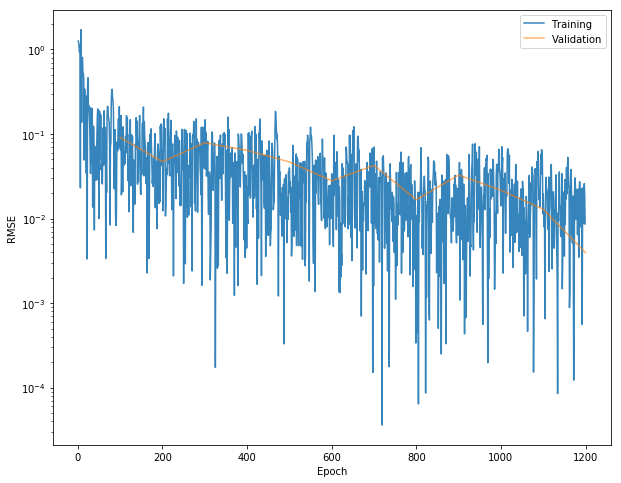

Step:  1300  MSE:  0.0696841  Val:  0.0265923 LR:  0.0032455131418420114


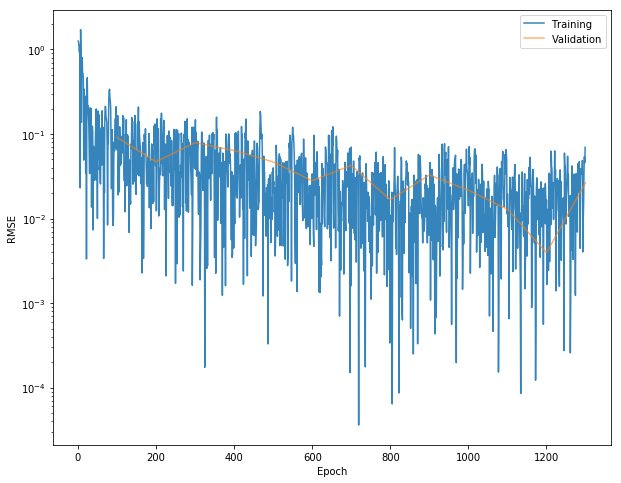

Step:  1400  MSE:  0.0103512  Val:  0.00399849 LR:  0.0031491181560161616


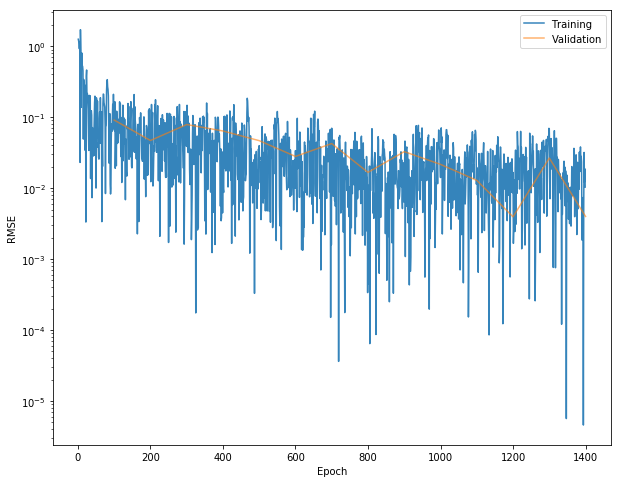

Step:  1500  MSE:  0.021457  Val:  0.0147981 LR:  0.0030555861976643253


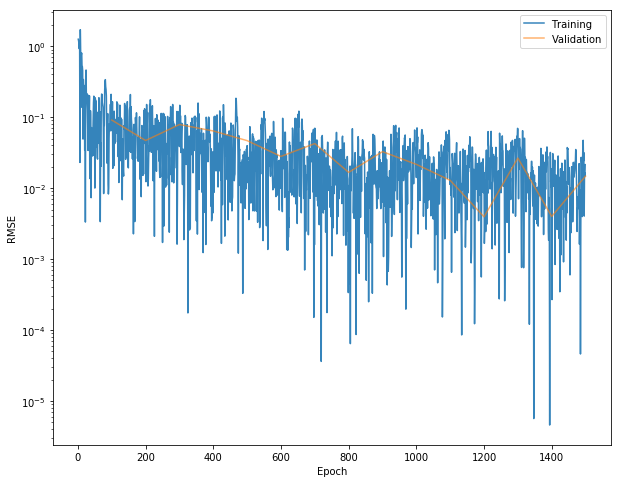

Step:  1600  MSE:  0.019885  Val:  0.025923 LR:  0.0029351839096874222


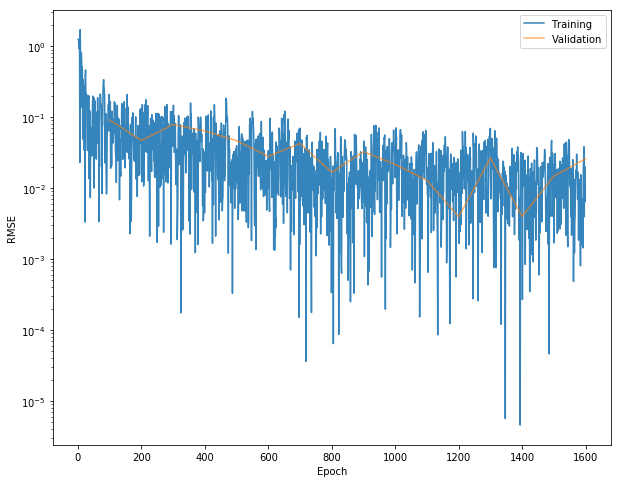

Step:  1700  MSE:  0.0206624  Val:  0.0148335 LR:  0.0028480060123857957


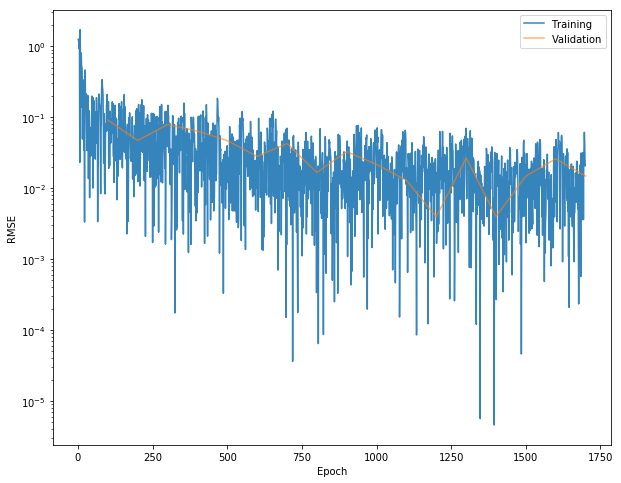

Step:  1800  MSE:  0.0170651  Val:  0.0141061 LR:  0.0027634173858119247


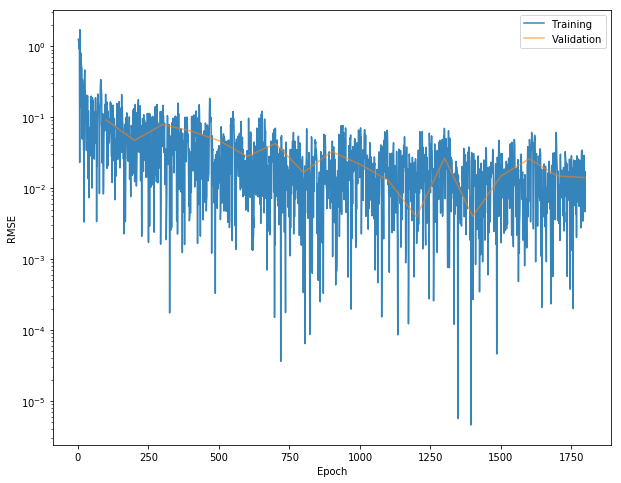

Step:  1900  MSE:  0.0176513  Val:  0.0262934 LR:  0.0026545277147755654


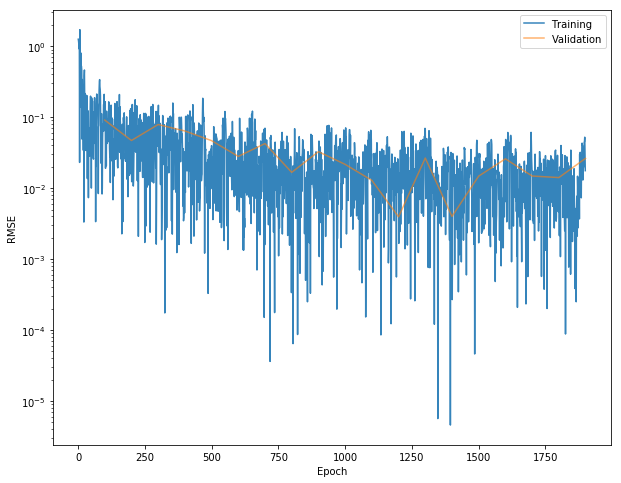

Step:  2000  MSE:  0.0131525  Val:  0.0145853 LR:  0.0025756855871190165


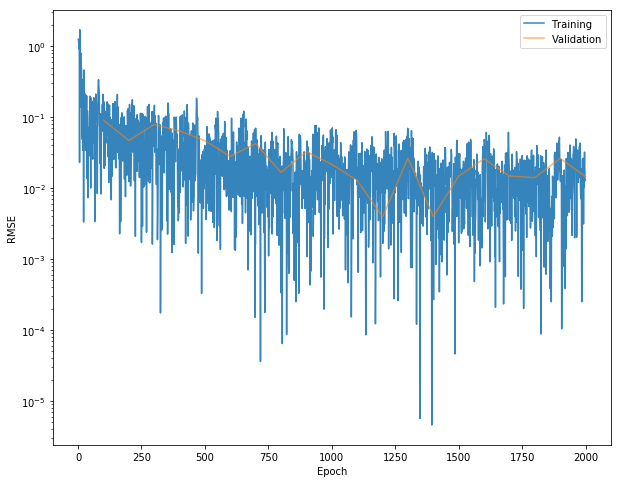

Step:  2100  MSE:  0.0131463  Val:  0.027222 LR:  0.0024991851494959947


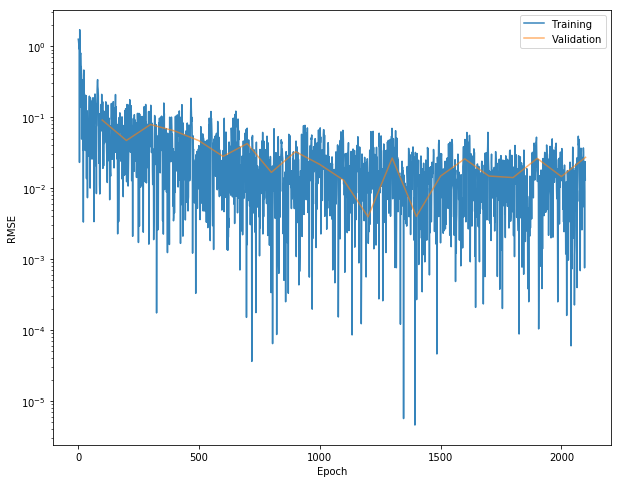

Step:  2200  MSE:  0.0145393  Val:  0.014718 LR:  0.002400707282857106


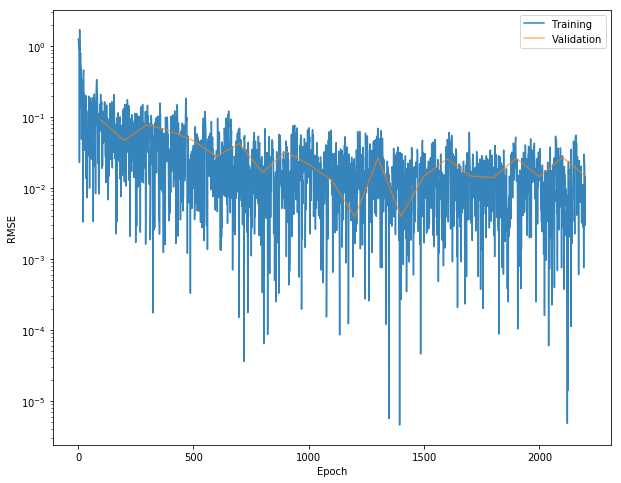

Step:  2300  MSE:  0.0226255  Val:  0.0134886 LR:  0.002329403875848967


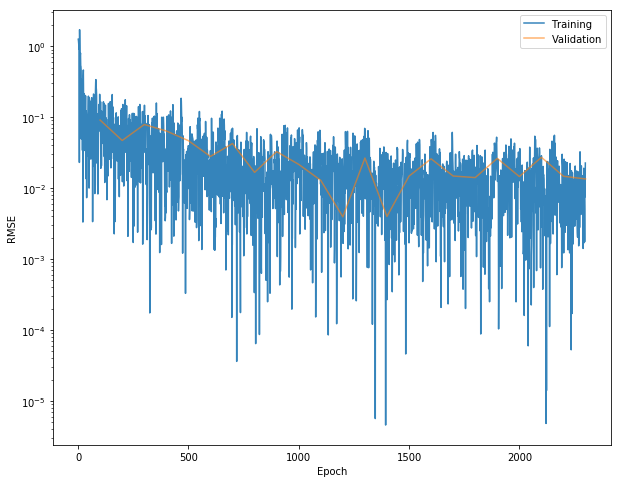

Step:  2400  MSE:  0.00161425  Val:  0.0210084 LR:  0.002260218251332377


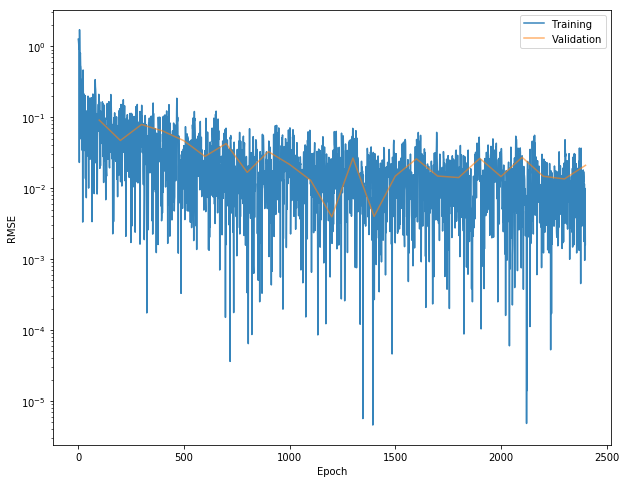

Step:  2500  MSE:  0.0123517  Val:  0.0141626 LR:  0.0021711566339590585


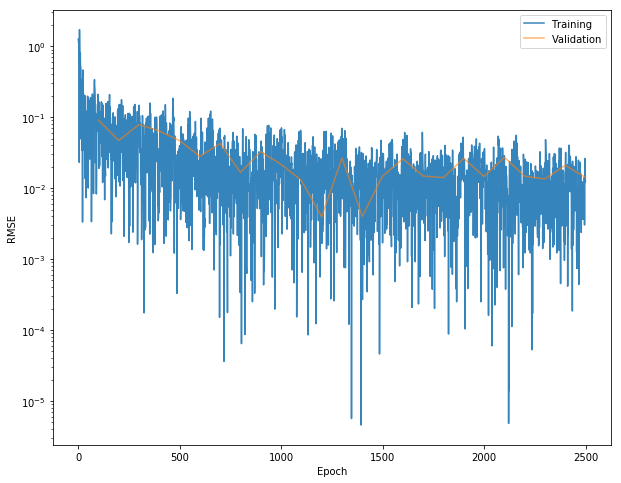

Step:  2600  MSE:  0.0243486  Val:  0.00793935 LR:  0.0021066711107738407


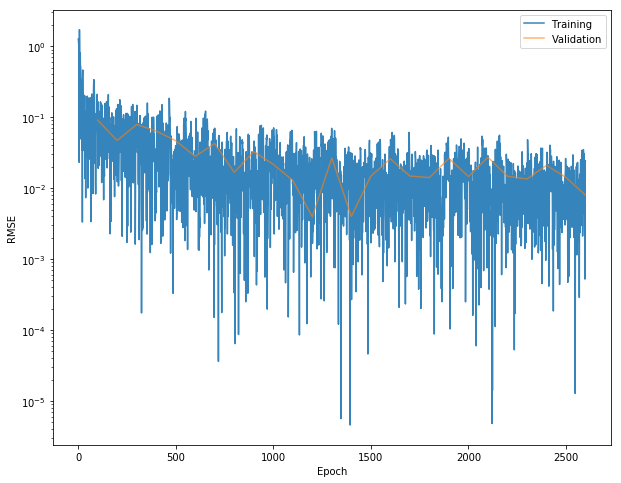

Step:  2700  MSE:  0.00324457  Val:  0.00021179 LR:  0.0020441008721127467


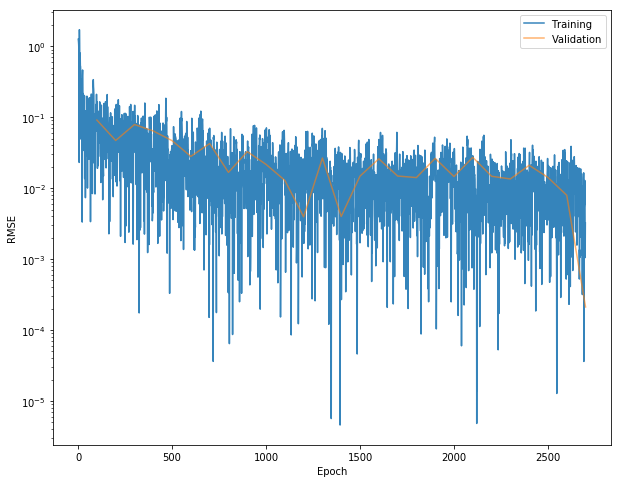

Step:  2800  MSE:  0.0194698  Val:  0.0270959 LR:  0.0019635551417890246


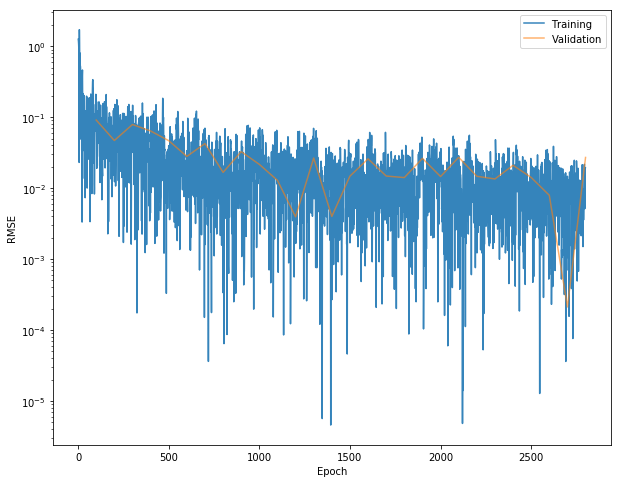

Step:  2900  MSE:  0.0082135  Val:  0.0157947 LR:  0.0019052355905227487


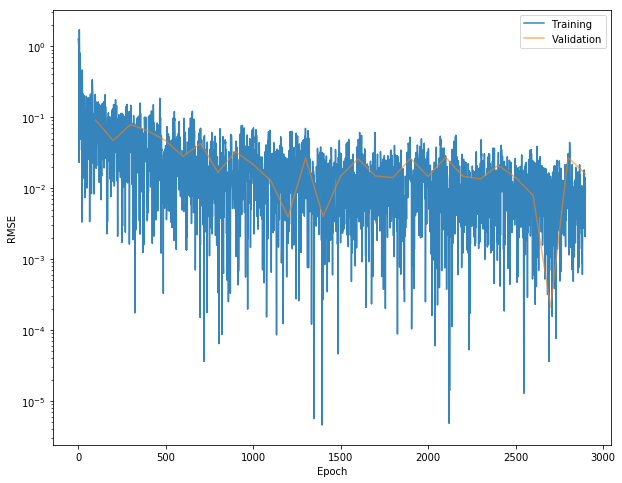

Step:  3000  MSE:  0.000870207  Val:  0.00728903 LR:  0.0018486481882486324


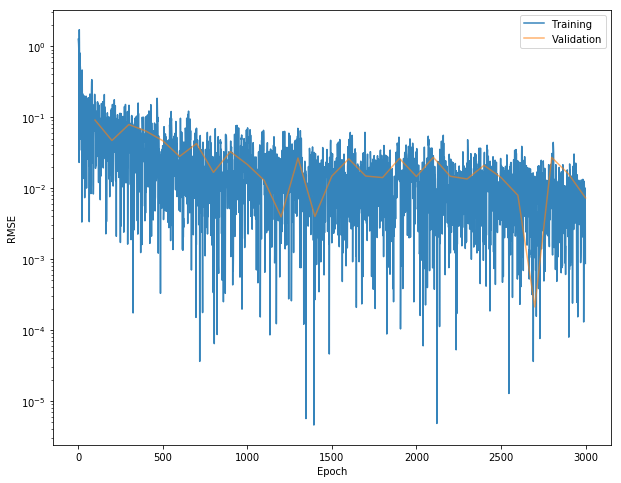

Step:  3100  MSE:  0.00481248  Val:  0.00254279 LR:  0.0017758040735253652


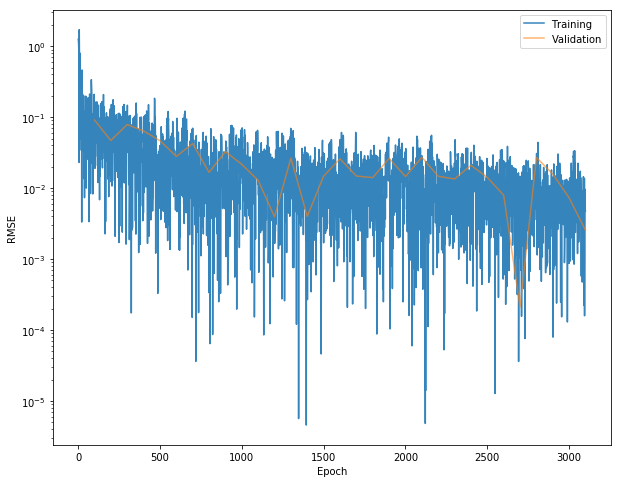

Step:  3200  MSE:  0.0094313  Val:  0.00909525 LR:  0.0017230609167375884


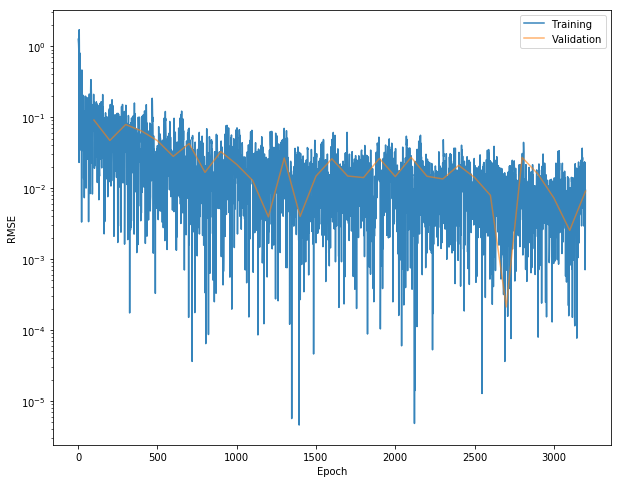

Step:  3300  MSE:  0.00730548  Val:  0.00282596 LR:  0.0016718842844495655


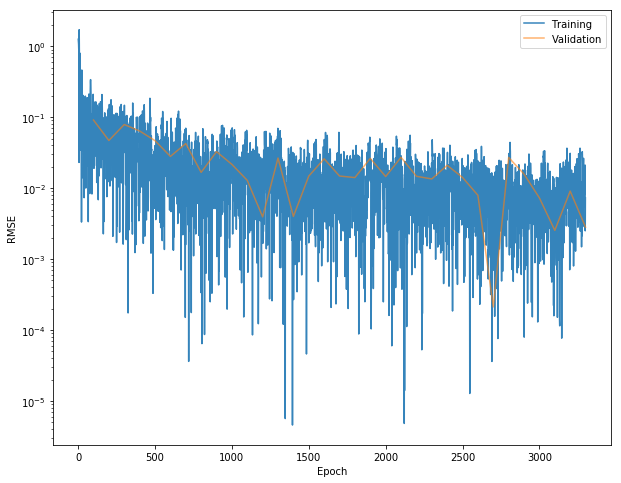

Step:  3400  MSE:  0.00962758  Val:  0.00365749 LR:  0.0016060053728239577


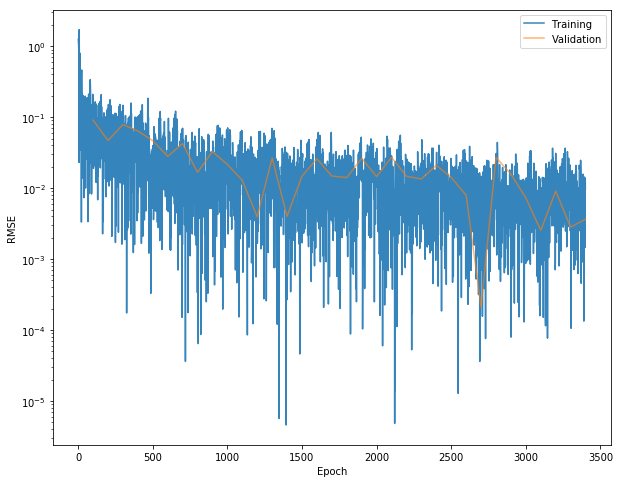

Step:  3500  MSE:  0.0202315  Val:  0.0139324 LR:  0.0015583054072457133


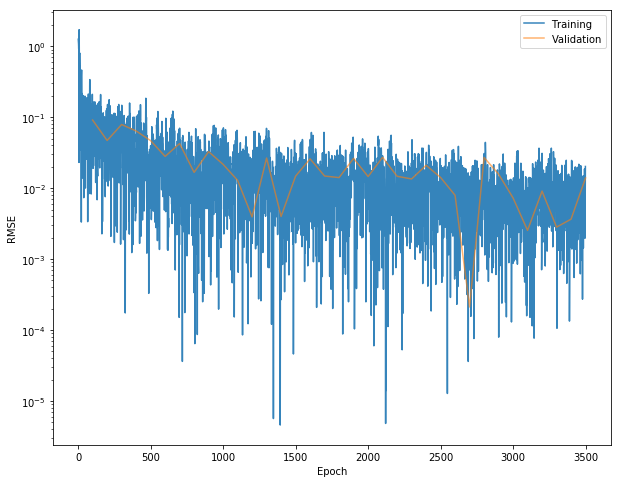

Step:  3600  MSE:  0.0198486  Val:  0.00694178 LR:  0.0015120221783451082


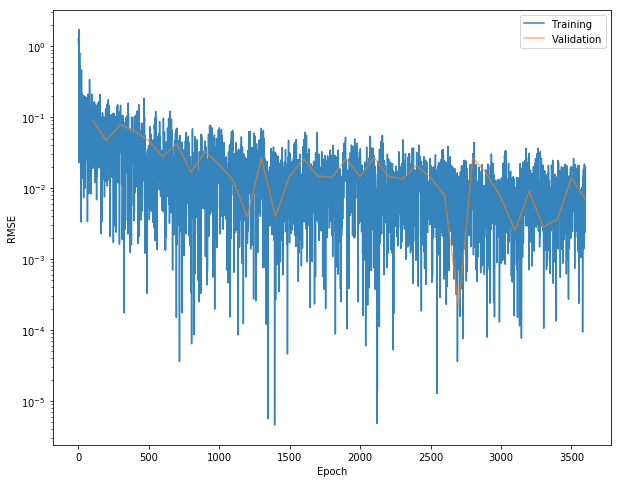

Step:  3700  MSE:  0.00213312  Val:  0.0029982 LR:  0.0014524424715498191


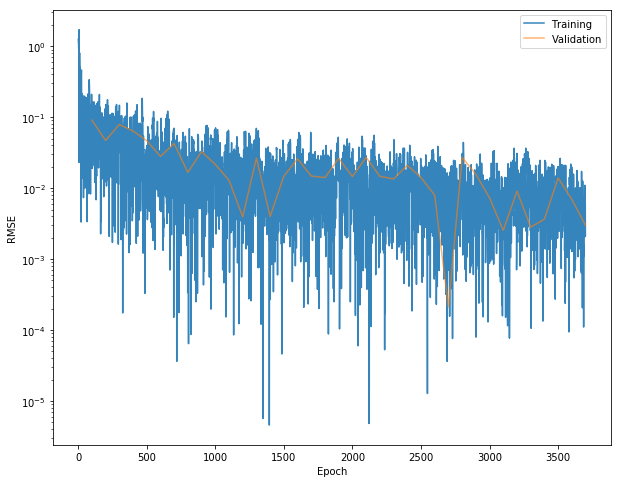

Step:  3800  MSE:  0.0195487  Val:  0.00862788 LR:  0.0014093034777023178


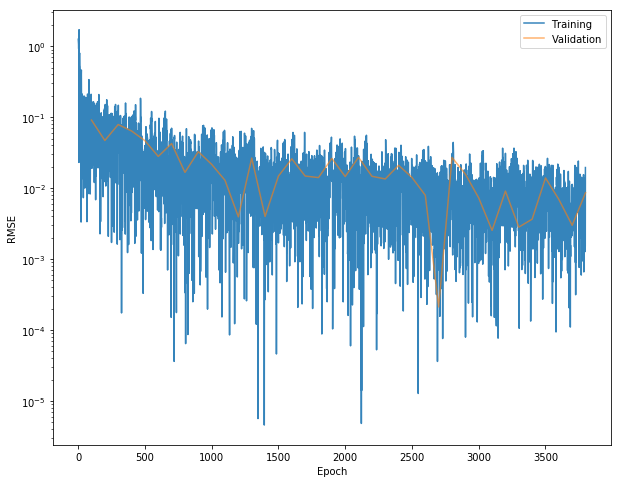

Step:  3900  MSE:  0.00329233  Val:  0.00132006 LR:  0.0013674457551110812


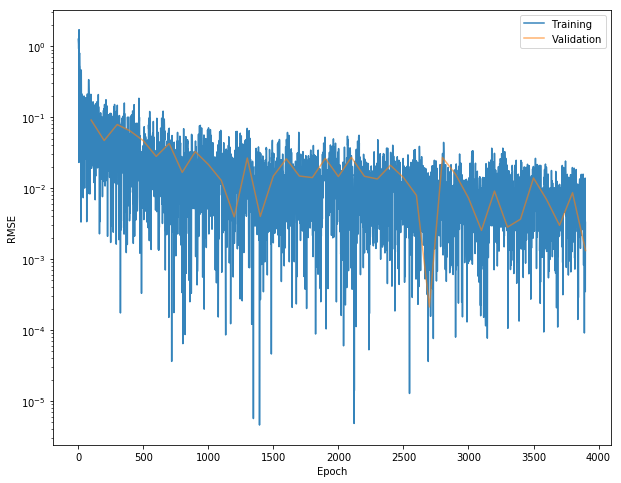

Step:  4000  MSE:  0.00400063  Val:  0.0135116 LR:  0.0013135629362511416


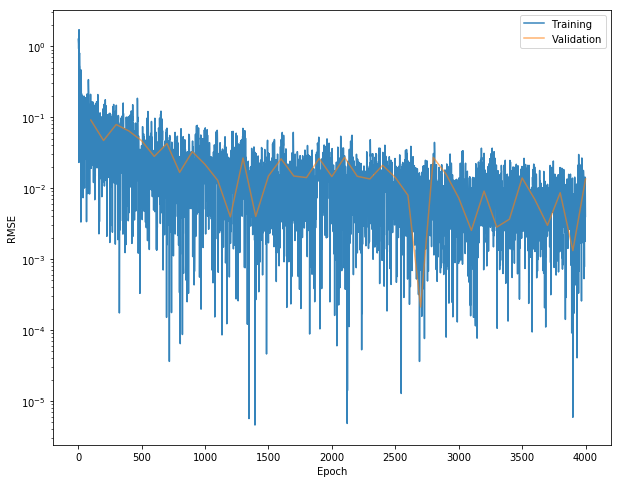

Step:  4100  MSE:  0.000839399  Val:  0.00394225 LR:  0.0012745488034815464


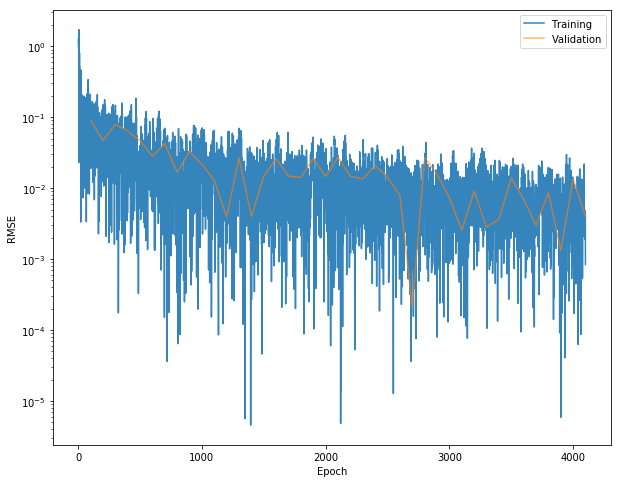

Step:  4200  MSE:  0.0105006  Val:  0.012288 LR:  0.001236693429469341


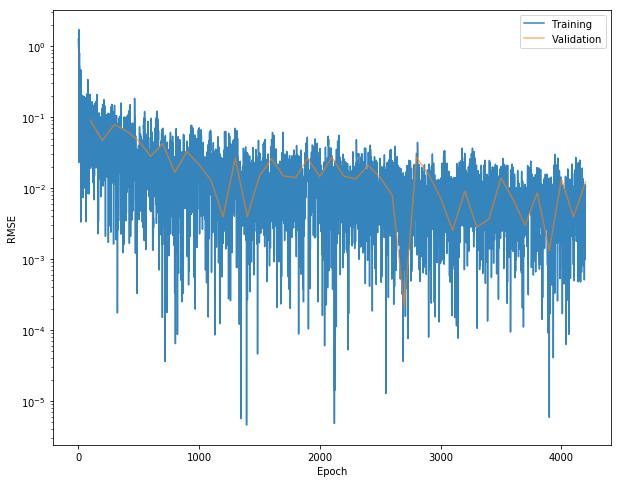

Step:  4300  MSE:  0.000891382  Val:  0.00944713 LR:  0.0011879627739414653


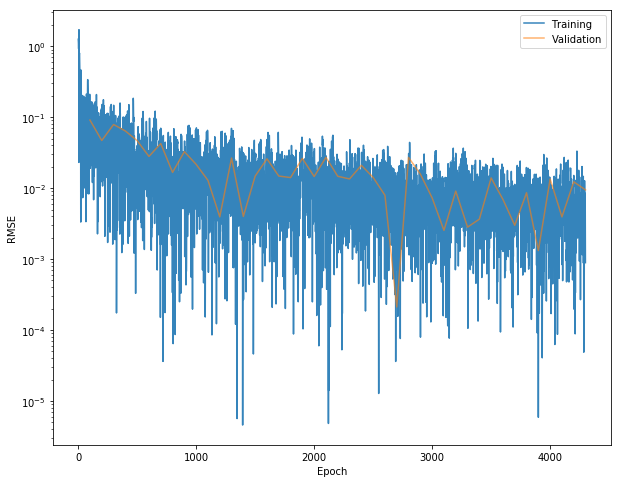

Step:  4400  MSE:  0.0214859  Val:  0.00828422 LR:  0.0011526790915926297


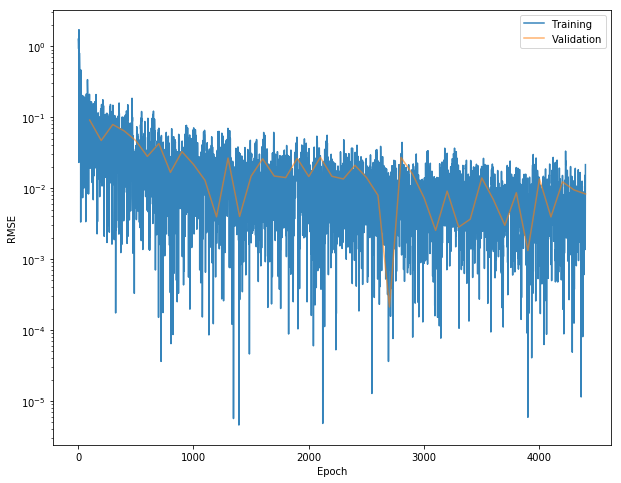

Step:  4500  MSE:  0.00984693  Val:  0.00916927 LR:  0.0011184433698932371


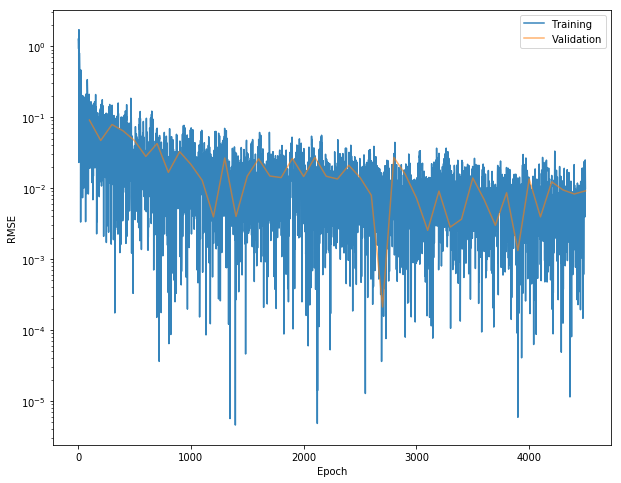

Step:  4600  MSE:  0.00687395  Val:  0.00371733 LR:  0.0010743722385303976


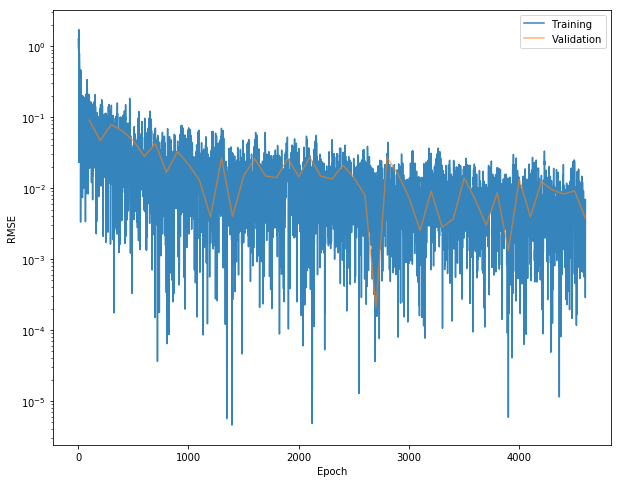

Step:  4700  MSE:  0.0022286  Val:  0.00744735 LR:  0.0010424623086738062


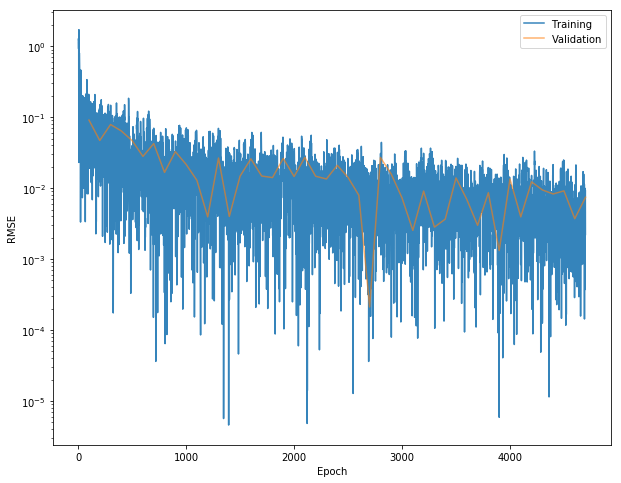

Step:  4800  MSE:  0.00474523  Val:  0.00139545 LR:  0.0010115001356438857


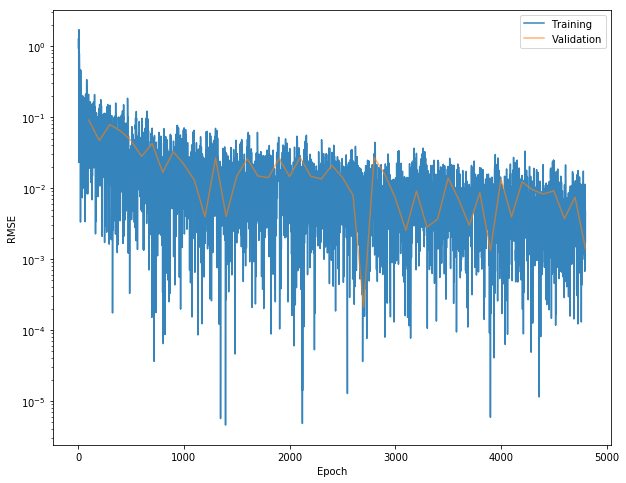

Step:  4900  MSE:  0.000512019  Val:  0.0046808 LR:  0.0009716429944139753


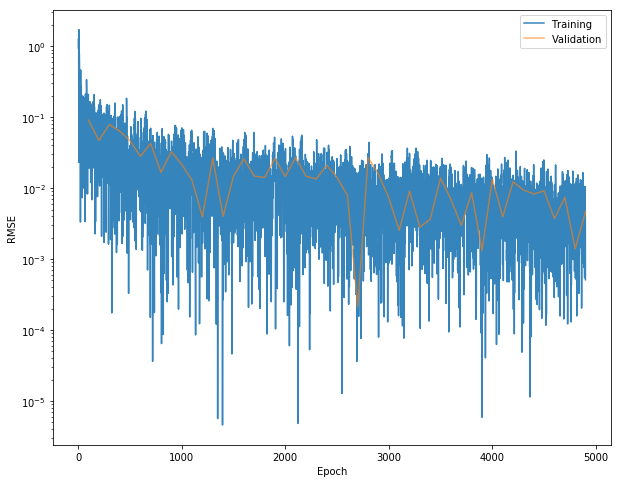

Step:  5000  MSE:  0.00566257  Val:  0.0018409 LR:  0.0009427842258368858


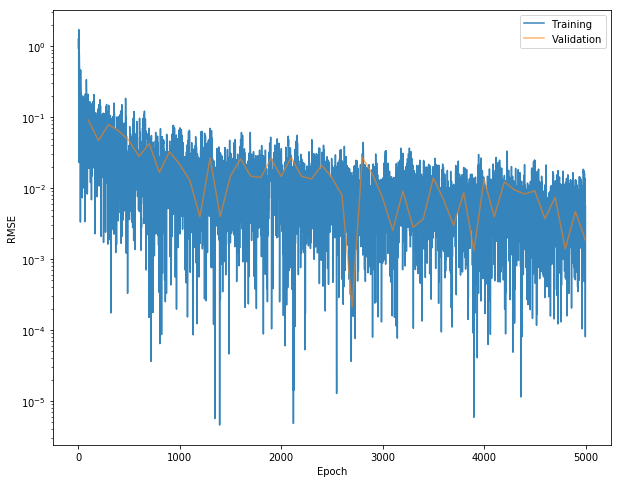

Computing sequence prediction - this may take a while. 
Done.


In [16]:
# simple parameters:
disp_period = 100
training_iters = 5000
lr = 0.005
lr_decay=0.99

with tf.device('/cpu:0'):
    tf.reset_default_graph()
    sess = get_session()
    SAVE_PATH = '/media/Big_Data/stefantj/tangonet.ckpt'

    model = tangoNet(batch_size = BATCH_SIZE, sess=sess)

        # Initializing the variables
    init = tf.global_variables_initializer()

    train_history = []
    val_history = []
    naive_history = []
    
    # Launch the graph
    sess.run(init)
    step = 1
    ind_train = []
    train_inds = []
    val_inds = []
    # Keep training until reach max iterations
    while step  < training_iters:
        if step % 30 is 0:
            lr *= lr_decay
        # these batches are of size 1?
        # for now, just grab a random sequence of data:
        batch_x, batch_y, istp = sample_minibatch(R_HISTORY*BATCH_SIZE)
        
        # Run optimization op (backprop)
        o,mse = sess.run([model.optimizer,model.rmse], feed_dict={model.data: batch_x, model.errs: batch_y, model.lr:[lr]})
        train_inds.append(step)
        train_history.append(mse)
        
        step += 1
        if step % disp_period is 0:
            # Calculate val accuracy:
            batch_x, batch_y, istp = sample_minibatch(R_HISTORY*BATCH_SIZE, False)
            vmse = sess.run(model.rmse, feed_dict={model.data: batch_x, model.errs: batch_y})
            val_history.append(vmse)
            val_inds.append(step)
            
            print('Step: ', step, ' MSE: ', mse, ' Val: ', vmse, 'LR: ', lr)
            plt.semilogy(train_inds, train_history,alpha=0.9)
            plt.semilogy(val_inds, val_history,alpha=0.6)
            plt.legend(['Training','Validation'])
            plt.xlabel('Epoch')
            plt.ylabel('RMSE')
            plt.show()


Computing sequence prediction - this may take a while. 
Done.
plotting from  300  to  500
High correlation (near 1) means we are predicting well.
Correlation between error and signal: 0.0361033003848


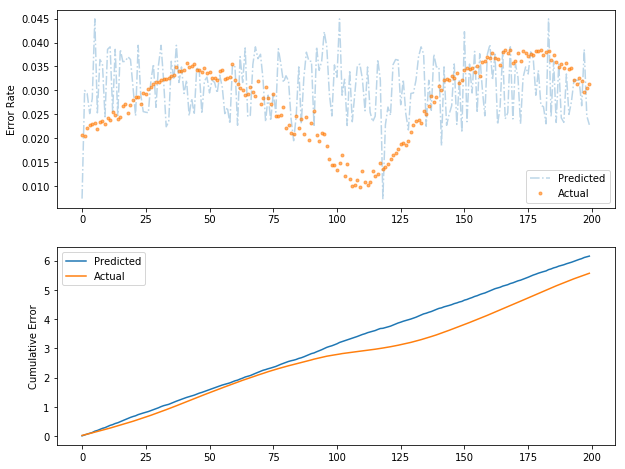

High correlation (near 1) means we are predicting noise.
Correlation between error and signal: 0.771917814711


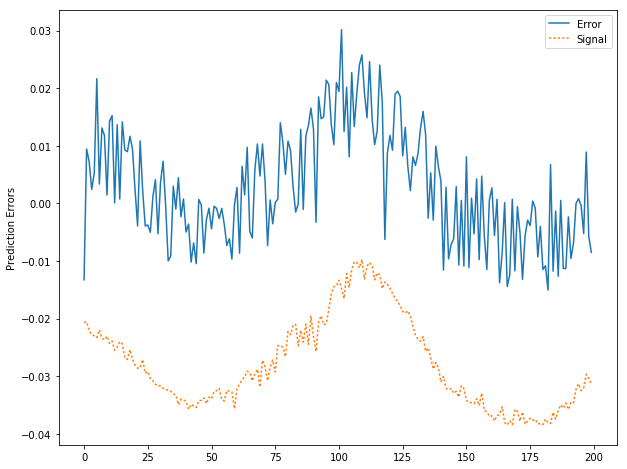

In [19]:
# Can load a previously computed prediction - useful if cold starting a notebook.

# Compute sequence prediction:
print('Computing sequence prediction - this may take a while. ')
y_pred = np.zeros(y_data.shape[0])
for k in range(BATCH_SIZE*R_HISTORY, flows_data.shape[0]):
    if k % 1000 is 0:
        print('k = ', k)
    batch_x, batch_y, istp = sample_minibatch(R_HISTORY*BATCH_SIZE, k)
    pred = sess.run(model.prediction, feed_dict={model.data: batch_x, model.errs: batch_y})
    y_pred[k] = pred[-1]
np.save('rnn_prediction', y_pred)
print('Done.')

# Blue background corresponds to data used during training
def plot_data(ns, ne):    

    print('plotting from ', ns, ' to ', ne)
    
    print('High correlation (near 1) means we are predicting well.')
    m1 = y_data[ns:ne].mean()
    c1 = np.sqrt(np.correlate(y_data[ns:ne]-m1,y_data[ns:ne]-m1)[0])
    m2 = y_pred[ns:ne].mean()
    c2 = np.sqrt(np.correlate(y_pred[ns:ne]-m2,y_pred[ns:ne]-m2)[0])
    c12 = (np.correlate(y_data[ns:ne]-m1,y_pred[ns:ne]-m2))[0]/(c1*c2)
    print('Correlation between error and signal:', (np.abs(c12)))
    
    plt.subplot(2,1,1)
    plt.ylabel('Error Rate')
    plt.plot(y_pred[ns:ne],'-.',alpha=0.3)
    plt.plot(y_data[ns:ne],'.',alpha=0.6)
#        plt.axvspan(0,N_training, facecolor='b',alpha=0.1)
    plt.legend(['Predicted','Actual'])

    plt.subplot(2,1,2)
    plt.ylabel('Cumulative Error')
    plt.plot(np.cumsum(y_pred[ns:ne]))
    plt.plot(np.cumsum(y_data[ns:ne]))
#        plt.axvspan(0,N_training, facecolor='b',alpha=0.1)
    plt.legend(['Predicted','Actual'])
    plt.show()

def plot_error(ns, ne):
    print('High correlation (near 1) means we are predicting noise.')
    m1 = y_data[ns:ne].mean()
    c1 = np.sqrt(np.correlate(y_data[ns:ne]-m1,y_data[ns:ne]-m1)[0])
    m2 = np.mean(y_pred[ns:ne]-y_data[ns:ne])
    c2 = np.sqrt(np.correlate(y_pred[ns:ne]-m2-y_data[ns:ne],y_pred[ns:ne]-m2-y_data[ns:ne])[0])
    c12 = (np.correlate(y_data[ns:ne]-m1,y_pred[ns:ne]-y_data[ns:ne]-m2))[0]/(c1*c2)
    print('Correlation between error and signal:', (np.abs(c12)))
    
    plt.ylabel('Prediction Errors')
    plt.plot(y_pred[ns:ne]-y_data[ns:ne])
    plt.plot(-y_data[ns:ne],':')
    plt.legend(['Error', 'Signal'])
    plt.show()


#plt.title('Learning Curve')
#naive_val = 0
#for k in range(y_data.shape[0]):
#    naive_val += calc_rmse(y_data[k,:],np.zeros(OUTPUT_DIM))
#naive_val /= y_data.shape[0]

#plt.plot(train_history,'.',alpha=0.3)
#plt.plot(val_history,'.',alpha=0.3)
#plt.plot(naive_val*np.ones_like(train_history),':')
#plt.legend(['Training','Validation','Naive'])
#plt.xlabel('Epoch')
#plt.ylabel('RMSE')
#plt.show()


plot_data(300,500)
plot_error(300,500)
